## Predictive Modeling

**Goal:** Our objective is to forecast *next-day hourly* electricity demand using weather and temporal features.

**Pipeline:**
1. **Problem Formulation:** 24-hour ahead forecasting.
2. **Baseline:** Naive forecast = today’s demand at the same hour.
3. **Feature Engineering:** lag features, temporal dummies, weather inputs.
4. **Models:** `Random Forest`, `XGBoost`, `SARIMA`, `LSTM`
5. **Validation:** Time-series split + GridSearchCV.
6. **Metrics:** `MAE`, `RMSE`, `MAPE`.
7. **Ensemble:** Stacking of top two models.
8. **Comparison:** Baseline vs. each model vs. ensemble.


## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor




2025-05-08 22:14:54.212355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and clean the dataset by adding autoregressive demand lags `(1h, 24h, 48h)`, shifting to create the `24-hour-ahead target`, and dropping rows with missing values. Then build a preprocessing pipeline that standardizes all numeric features and one-hot encodes the `season` and ` city` categorical variables.

In [2]:
# 1) Load your cleaned, merged CSV
df = pd.read_csv('preprocessed_dataset.csv', parse_dates=['timestamp'])

for lag in [1, 24, 48]:
    df[f'demand_lag_{lag}'] = df.groupby('city')['demand'].shift(lag)

# 2) Extract target: 24h-ahead demand per city
df['target'] = df.groupby('city')['demand'].shift(-24)

# 3) Drop last 24 rows per city (no target) and any NaNs
df = df.dropna(subset=['target'] + [f'demand_lag_{l}' for l in (1,24,48)])

# 4) Time features (if not already present)
df['hour']      = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month']     = df['timestamp'].dt.month

# 5) One-hot encode 'season' and 'city'
cat_feats = ['season','city']
num_feats = [
  'temperature','humidity','windSpeed','pressure',
  'precipIntensity','precipProbability',
  'hour','dayofweek','month',
  'demand_lag_1','demand_lag_24','demand_lag_48'
]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_feats)
])


Split the data chronologically—everything before 2020 for training and from 2020 onward for testing—and then separate the predictors (`num_feats + cat_feats`) and the target (`target`) into `X_train`, `y_train`, `X_test`, and `y_test`.

In [3]:
# use all data before 2020 as training, 2020 onward as test
train = df[df['timestamp'] < '2020-01-01']
test  = df[df['timestamp'] >= '2020-01-01']

X_train, y_train = train[num_feats+cat_feats], train['target']
X_test,  y_test  = test [num_feats+cat_feats],  test ['target']


## **The “naïve” forecast**
 simply uses yesterday’s demand for the same hour as today’s prediction (i.e. `demand.shift(24)`), giving you a one‐day‐persistence benchmark. The code then masks out any missing values and computes MAE, RMSE and MAPE between that naïve prediction and the true 24-hour‐ahead target.

In [4]:
# naive = demand 24h ago ⇒ same as target shift(24)
test['naive'] = test.groupby('city')['demand'].shift(24)
mask = ~test['naive'].isna()

mae_naive = mean_absolute_error(test.loc[mask,'target'], test.loc[mask,'naive'])
rmse_naive = np.sqrt(mean_squared_error(test.loc[mask,'target'], test.loc[mask,'naive']))
mape_naive = (np.abs((test["target"] - test["naive"]) / test["target"])).mean() * 100
#print(f"Naïve MAE: {mae_naive:.3f}, RMSE: {rmse_naive:.3f}")

print(f"Naïve MAE:  {mae_naive:.3f}")
print(f"Naïve RMSE: {rmse_naive:.3f}")
print(f"Naïve MAPE: {mape_naive:.2f}%")

Naïve MAE:  0.352
Naïve RMSE: 0.620
Naïve MAPE: 300.17%


/var/folders/90/zq_j_tyj1js6cf4j8sl7zc3m0000gn/T/ipykernel_2279/2867712080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive'] = test.groupby('city')['demand'].shift(24)


## **RandomForest**

Random Forest is an ensemble method that builds many decision trees on bootstrapped subsets of the data and random subsets of features, then averages their predictions to reduce overfitting and variance. It can capture complex, nonlinear relationships and is robust to noise and missing values.

This chunk of code sets up a pipeline that first applies your preprocessing (`preprocessor`), then fits a `RandomForestRegressor`. It uses a 5-fold time-series split to grid-search over 100 vs 300 trees and max depths 10, 30 or unlimited, optimizing for lowest MAE; after finding the best hyperparameters it fits on all training data and generates `rf_pred` on the test set.


In [ ]:
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [10, 30, None]
}

tscv = TimeSeriesSplit(n_splits=5)
gs_rf = GridSearchCV(pipe_rf, param_grid, cv=tscv,
                     scoring='neg_mean_absolute_error', n_jobs=-1)
gs_rf.fit(X_train, y_train)

print("RF best params:", gs_rf.best_params_)
rf_pred = gs_rf.predict(X_test)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^

## **XGboost**

XGBoost is a gradient-boosted tree ensemble that iteratively fits new trees to the residuals of prior ones, optimizing a differentiable loss (here MAE). It includes built-in regularization and learning-rate control to prevent overfitting and achieve high accuracy on tabular data.

This sets up an XGBoost pipeline that first applies your preprocessing (`preprocessor`), then fits an `XGBRegressor`. It grid-searches over 100 vs. 300 trees, max depths of 3 or 6, and learning rates of 0.05 or 0.1—using the same time-series CV and MAE criterion—then trains on all the data with the best settings and produces `xgb_pred` on the test set.


In [26]:
pipe_xgb = Pipeline([
    ('prep', preprocessor),
    ('xgb', xgb.XGBRegressor(random_state=42, verbosity=0))
])

param_grid = {
    'xgb__n_estim'
    'ators': [100, 300],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.05, 0.1]
}

gs_xgb = GridSearchCV(pipe_xgb, param_grid, cv=tscv,
                      scoring='neg_mean_absolute_error', n_jobs=-1)
gs_xgb.fit(X_train, y_train)

print("XGB best params:", gs_xgb.best_params_)
xgb_pred = gs_xgb.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]



XGB best params: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}


##  SARIMA with Exogenous Weather & Temporal Features


This block converts your scaled numeric and one-hot features into exogenous regressors, then fits a **SARIMAX(1,1,1)x(1,1,1,24)** model—capturing both non-seasonal and 24-hour seasonal ARIMA components—on the training period. It then uses those exogenous inputs to forecast the test period’s demand and reports MAE/RMSE against the true values.


In [7]:
# ── 0) Make sure timestamp is datetime ────────────────────────────────
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ── 1) Define train/test masks by date ────────────────────────────────
train_mask = df['timestamp'] < '2020-01-01'
test_mask  = ~train_mask

# ── 2) Build & scale exogenous DataFrame ─────────────────────────────
exog = pd.get_dummies(df[num_feats + cat_feats], drop_first=True)
scaler_exog = StandardScaler()
exog[num_feats] = scaler_exog.fit_transform(exog[num_feats])

train_exog = exog.loc[train_mask].fillna(0).astype('float64')
test_exog  = exog.loc[test_mask] .fillna(0).astype('float64')

# ── 3) Prepare endogenous series ──────────────────────────────────────
train_endog = df.loc[train_mask, 'target']
test_endog  = df.loc[test_mask,  'target']

# ── 4) Fit SARIMAX with exogenous regressors ──────────────────────────
model = sm.tsa.statespace.SARIMAX(
    endog=train_endog,
    exog=train_exog,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

# ── 5) Forecast the next len(test_exog) steps ──────────────────────────
n_steps    = len(test_exog)
sarima_pred = res.forecast(steps=n_steps, exog=test_exog)

# (Optional) align to actual timestamp index
sarima_pred.index = df.loc[test_mask, 'timestamp'].values

# ── 6) Compute metrics ────────────────────────────────────────────────
mae  = mean_absolute_error(test_endog, sarima_pred)
rmse = np.sqrt(mean_squared_error(test_endog, sarima_pred))
print(f"SARIMA MAE: {mae:.3f}, RMSE: {rmse:.3f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                31405
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -14632.732
Date:                            Mon, 05 May 2025   AIC                          29323.464
Time:                                    15:33:39   BIC                          29565.704
Sample:                                         0   HQIC                         29401.027
                                          - 31405                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
temperature          -0.0007      0.004     -0.166      0.868      -0.008       0.007
humidity      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA MAE: 2.257, RMSE: 2.468


## LSTM

LSTM (Long Short-Term Memory) is a gated recurrent neural network that can learn long-range dependencies in sequential data, making it ideal for time-series forecasting. Here, we feed a 24-hour sliding window of scaled features into an LSTM layer (followed by a Dense output) and train it with MAE loss and early stopping to predict the next hour’s demand.

This loop trains a separate LSTM for each city by scaling its features (weather, time, and lagged demand), sliding a 24-hour window to form input sequences, and fitting with MAE loss and early stopping. After predicting and inverting the scaling, it computes MAE/RMSE/MAPE per city and stores both the metrics in `results_df` and the timestamp-aligned forecasts in `pred_df` for later analysis.


In [10]:
# Prepare to collect results and predictions
cities = df['city'].unique()
results = []
predictions_dict = {}

# LSTM hyperparams
WINDOW = 24
EPOCHS = 15
BATCH_SIZE = 32

for city in cities:
    print(f"\n=== Training LSTM for {city.title()} ===")
    city_df = df[df['city'] == city].set_index('timestamp')

    # Scale features + target
    cols = num_feats + ['target']
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(city_df[cols])

    # Build sequences
    def create_sequences(data, window=WINDOW):
        X, y = [], []
        for i in range(len(data) - window):
            X.append(data[i:i+window, :-1])
            y.append(data[i+window,   -1])
        return np.array(X), np.array(y)

    X_all, y_all = create_sequences(scaled, WINDOW)

    # Train/test split (80/20)
    split = int(len(X_all) * 0.8)
    X_tr, y_tr = X_all[:split], y_all[:split]
    X_te, y_te = X_all[split:], y_all[split:]

    # Build & train LSTM
    model = Sequential([
        LSTM(50, input_shape=(X_tr.shape[1], X_tr.shape[2])),
        Dense(1)
    ])
    model.compile(loss='mae', optimizer='adam')
    model.fit(
        X_tr, y_tr,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0
    )

    # Predict & invert scaling
    lstm_scaled = model.predict(X_te).flatten()
    dummy       = np.zeros((len(lstm_scaled), scaled.shape[1]))
    dummy[:, -1] = lstm_scaled
    lstm_pred   = scaler.inverse_transform(dummy)[:, -1]

    # Align with timestamps
    idx  = city_df.index[WINDOW + split:]
    actual = city_df['target'].loc[idx]
    pred   = pd.Series(lstm_pred, index=idx)

    # Store predictions
    predictions_dict[city] = pred

    # Compute metrics
    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = (np.abs((actual - pred) / actual).mean()) * 100

    print(f"{city.title()} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    results.append({'city': city, 'MAE': mae, 'RMSE': rmse, 'MAPE(%)': mape})

# Summary DataFrame
results_df = pd.DataFrame(results).set_index('city')
display(results_df)

# Build combined DataFrame for plotting
all_preds = []
for city, pred in predictions_dict.items():
    city_df = df[df['city'] == city].set_index('timestamp')
    actual = city_df['target'].loc[pred.index]
    df_temp = pd.DataFrame({
        'timestamp':  pred.index,
        'city':       city,
        'actual':     actual.values,
        'predicted':  pred.values
    })
    all_preds.append(df_temp)

pred_df = pd.concat(all_preds)




=== Training LSTM for Dallas ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Dallas → MAE: 0.58, RMSE: 0.76, MAPE: 55.86%

=== Training LSTM for Houston ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Houston → MAE: 0.45, RMSE: 0.61, MAPE: 40.82%

=== Training LSTM for La ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
La → MAE: 0.42, RMSE: 0.62, MAPE: 41.55%

=== Training LSTM for Nyc ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Nyc → MAE: 0.21, RMSE: 0.28, MAPE: 348.49%

=== Training LSTM for Philadelphia ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Philadelphia → MAE: 0.14, RMSE: 0.19, MAPE: 98.32%

=== Training LSTM for Phoenix ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Phoenix → MAE: 0.18, RMSE: 0.26, MAPE: 517.79%

=== Training LSTM for San Antonio ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
San Antonio → MAE: 0.31, RMSE: 0.41, MAPE: 717.90%

=== Training LSTM for San Diego ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
San Diego → MAE: 0.08, RMSE: 0.11, MAPE: 9.19%

=== Training LSTM for San Jose ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
San Jose → MAE: 0.36, RMSE: 0.49, MAPE: 124.30%

=== Training LSTM for Seattle ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Seattle → MAE: 0.03, RMSE: 0.04, MAPE: 2.84%


,MAE,RMSE,MAPE(%)
city,,,
dallas,0.581555,0.758607,55.857578
houston,0.451991,0.607247,40.824943
la,0.422131,0.622382,41.550877
nyc,0.214357,0.282535,348.489319
philadelphia,0.143462,0.192401,98.321695
phoenix,0.180441,0.255406,517.785633
san antonio,0.311536,0.412203,717.900078
san diego,0.082395,0.107650,9.190576
san jose,0.360810,0.486507,124.298517


## Visualizing LSTM results

In [20]:
# --- 1) Prep ---
cities = pred_df['city'].unique()
max_d = pred_df[['actual','predicted']].max().max() * 1.05

# --- 2) Build figure with 2 traces per city (hidden by default) ---
fig = go.Figure()
for i, city in enumerate(cities):
    dfc = pred_df[pred_df['city']==city]

    fig.add_trace(go.Scatter(
        x=dfc['timestamp'], y=dfc['actual'],
        mode='lines+markers',
        line=dict(color='teal', width=2),
        marker=dict(size=6),
        name='Actual',
        visible=(i==0)
    ))
    fig.add_trace(go.Scatter(
        x=dfc['timestamp'], y=dfc['predicted'],
        mode='lines+markers',
        line=dict(color='deeppink', width=2, dash='dash'),
        marker=dict(symbol='x', size=6),
        name='Predicted',
        visible=(i==0)
    ))

# --- 3) Dropdown buttons ---
buttons = []
for i, city in enumerate(cities):
    vis = [False] * len(fig.data)
    vis[2*i]   = True
    vis[2*i+1] = True
    buttons.append(dict(
        label=city.title(),
        method='update',
        args=[
            {'visible': vis},
            {'title': f"{city.title()}: Actual vs Predicted",
             'yaxis': {'range': [0, max_d]}}
        ]
    ))

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=0.1, y=1.15)],
    title=f"{cities[0].title()}: Actual vs Predicted",
    xaxis_title="Timestamp",
    yaxis_title="Hourly Demand (MWh)",
    yaxis=dict(range=[0, max_d]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, x=0.5, xanchor='center')
)

fig.show()


**General Insights from Forecast Plot**

- **Flat “Predicted” Trend:** The LSTM’s predictions (pink crosses) cluster tightly around ~1.4 MWh, showing very little variation compared to the true demand series (teal).  
- **Under-/Over-Smoothing:** The model consistently **underestimates peaks** (fails to reach the higher spikes in actual demand) and **overestimates troughs** (doesn’t drop as low as the real lows), indicating it’s regressing toward the mean.  
- **High Volatility in Actuals:** Actual hourly demand swings dramatically—often between 0.3 MWh and 4.0 MWh—reflecting strong short-term dynamics the model isn’t capturing.  
- **Bias Toward Historical Average:** Without strong autoregressive signals, the network defaults to the average load, smoothing out all the true spikes and dips.  
- **Next Steps:** To improve fidelity, incorporate lagged-demand features (e.g. demandₗₐg₁, demandₗₐg₂₄), richer cyclical encodings, or a hybrid CNN-LSTM structure that better retains recent context.  


In [24]:
df_plot = results_df.reset_index()

fig1 = px.bar(
    df_plot,
    x='city',
    y='MAE',
    title='LSTM: Mean Absolute Error by City',
    labels={'MAE': 'MAE (MWh)', 'city': 'City'},
    color_discrete_sequence=['thistle']
)
fig1.update_layout(xaxis_tickangle=-45)
fig1.show()

fig2 = px.bar(
    df_plot,
    x='city',
    y='MAPE(%)',
    title='LSTM: Mean Absolute Percentage Error by City',
    labels={'MAPE(%)': 'MAPE (%)', 'city': 'City'},
    color_discrete_sequence=['pink']
)
fig2.update_layout(xaxis_tickangle=-45)
fig2.show()


## Stacking Ensemble

This snippet sets up a stacking ensemble that combines your tuned `Random Fores`t and `XGBoos`t as base learners with a Linear Regression meta-learner under a `5-fold K-Fold` scheme. It wraps the stack in a pipeline to apply your preprocessing, fits it on the training data, then predicts on the test set and reports `MAE`, `RMSE`, and `MAPE` to quantify its forecasting performance.


In [27]:
# 1) Define the two base learners with their tuned hyperparameters
estimators = [
    ('rf',  RandomForestRegressor(
                random_state=42,
                n_estimators=gs_rf.best_params_['rf__n_estimators'],
                max_depth=gs_rf.best_params_['rf__max_depth']
            )),
    ('xgb', xgb.XGBRegressor(
                random_state=42, verbosity=0,
                n_estimators=gs_xgb.best_params_['xgb__n_estimators'],
                max_depth=gs_xgb.best_params_['xgb__max_depth'],
                learning_rate=gs_xgb.best_params_['xgb__learning_rate']
            ))
]

# 2) Create the stacking regressor with a linear meta‐learner and 5‐fold KFold
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    passthrough=False
)

# 3) Build a pipeline to include preprocessing
pipe_stack = Pipeline([
    ('prep',  preprocessor),  # your ColumnTransformer from earlier
    ('stack', stack)
])

# 4) Train on your training set
print("Training stacking ensemble…")
pipe_stack.fit(X_train, y_train)

# 5) Predict on the test set
stack_pred = pipe_stack.predict(X_test)

# 6) Compute evaluation metrics
mae_stack  = mean_absolute_error(y_test, stack_pred)
rmse_stack = np.sqrt(mean_squared_error(y_test, stack_pred))
mape_stack = (np.abs((y_test - stack_pred) / y_test).mean()) * 100

print(f"STACK MAE:  {mae_stack:.3f}")
print(f"STACK RMSE: {rmse_stack:.3f}")
print(f"STACK MAPE: {mape_stack:.2f}%")


Training stacking ensemble…
STACK MAE:  0.311
STACK RMSE: 0.494
STACK MAPE: 293.09%


## Visualizing Model Comparison

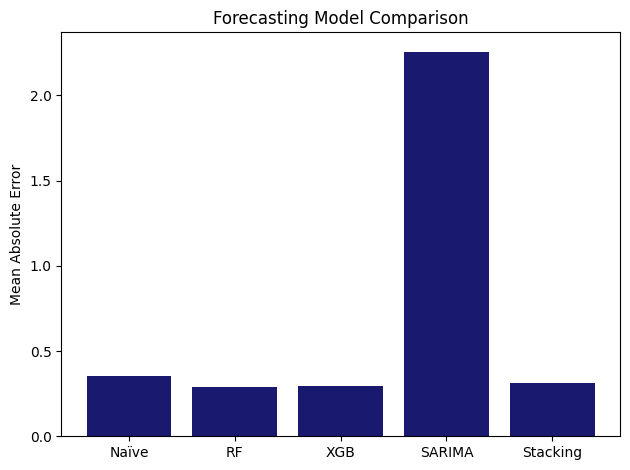

In [29]:
# recompute if needed:
mae_rf     = mean_absolute_error(y_test,     rf_pred)
mae_xgb    = mean_absolute_error(y_test,     xgb_pred)
mae_sarima = mean_absolute_error(test_endog, sarima_pred)

models = ['Naïve', 'RF', 'XGB', 'SARIMA', 'Stacking']
maes   = [mae_naive, mae_rf, mae_xgb, mae_sarima, mae_stack]

plt.figure()
plt.bar(models, maes, color = 'midnightblue')
plt.ylabel('Mean Absolute Error')
plt.title('Forecasting Model Comparison')
plt.tight_layout()
plt.show()


## Forecast Plot: Time-series chart of actual vs. predicted demand.

In [32]:
# 1) Prepare pred_df exactly as before
pred_df = test[['timestamp','city','target','naive']].copy()
pred_df['rf_pred']    = rf_pred
pred_df['xgb_pred']   = xgb_pred
pred_df['stack_pred'] = stack_pred

cities = pred_df['city'].unique()

# 2) Precompute each city’s own max (for its first 48 h)
city_max = {}
for city in cities:
    dfc = (pred_df[pred_df['city']==city]
           .set_index('timestamp')
           .sort_index()
           .iloc[:48])
    city_max[city] = dfc[['target','naive','rf_pred','xgb_pred','stack_pred']].max().max() * 1.05

# 3) Build the figure
fig = go.Figure()
for i, city in enumerate(cities):
    dfc = (pred_df[pred_df['city']==city]
           .set_index('timestamp')
           .sort_index()
           .iloc[:48])
    fig.add_trace(go.Scatter(
        x=dfc.index, y=dfc['target'], mode='lines+markers',
        name='Actual', visible=(i==0),
        line=dict(color='lightblue'), marker=dict(size=6)
    ))
    fig.add_trace(go.Scatter(
        x=dfc.index, y=dfc['naive'], mode='lines+markers',
        name='Naïve', visible=(i==0),
        line=dict(color='lightcoral', dash='dash'), marker=dict(symbol='circle-open')
    ))
    fig.add_trace(go.Scatter(
        x=dfc.index, y=dfc['rf_pred'], mode='lines+markers',
        name='RF', visible=(i==0),
        line=dict(color='mediumseagreen', dash='dot'), marker=dict(symbol='square')
    ))
    fig.add_trace(go.Scatter(
        x=dfc.index, y=dfc['xgb_pred'], mode='lines+markers',
        name='XGB', visible=(i==0),
        line=dict(color='orchid', dash='dashdot'), marker=dict(symbol='x')
    ))
    fig.add_trace(go.Scatter(
        x=dfc.index, y=dfc['stack_pred'], mode='lines+markers',
        name='Stack', visible=(i==0),
        line=dict(color='gold'), marker=dict(symbol='triangle-up')
    ))

# 4) Dropdown with per-city y-ranges
buttons = []
for i, city in enumerate(cities):
    vis = [False]*len(fig.data)
    for j in range(5):
        vis[5*i + j] = True
    buttons.append(dict(
        label=city.title(),
        method='update',
        args=[
            {'visible': vis},
            {
                'title': f"{city.title()}: First 48h Actual vs Predictions",
                'yaxis': {'range': [0, city_max[city]]}
            }
        ]
    ))

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=0.1, y=1.15)],
    title=f"{cities[0].title()}: First 48h Actual vs Predictions",
    xaxis_title="Timestamp",
    yaxis_title="Hourly Demand (MWh)",
    legend=dict(orientation='h', yanchor='bottom', y=1.02, x=0.5, xanchor='center'),
    margin=dict(t=100, b=50)
)

fig.show()


**Naïve baseline** roughly follows the true swings but often lags peaks and overshoots troughs.

**Random Forest & XGBoos**t both collapse to a near-constant, city-wide mean, indicating they have no “memory” of recent demand.

**Stacking ensemble** ends up even smoother, since it linearly blends two flat predictors.

Actual demand shows clear hour-to-hour variability that none of the tree-based models capture.